# TUNED or Cleaned up version of Linear Static Analysis
TODO : add either relu kernel zero at boundary
and/or add kernels of different length scales.
Also could try Matern kernel or other kernels that can mix different length scales.
For buckling could try some type of sine kernel?

In [1]:
# panel linear static inputs
# buckling inputs
# ----------------

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
(a, b) = (3, 1)

# choose kernel hyperparameters
Lx = 0.4; Ly = 0.4
Lx2 = 0.25; Ly2 = 0.25
c2 = 0.0

def q_load(x,y): # distributed load across the panel
    return 1.0 + 0.0 * x

2024-12-05 14:18:09.719265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733426289.730531   67189 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733426289.733914   67189 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 14:18:09.746686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


W0000 00:00:1733426291.333446   67189 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


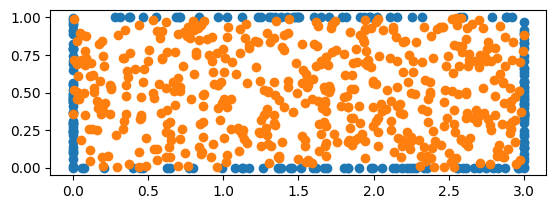

In [2]:
# compute the linear static analysis inputs and mesh domain of collocation pts
# ----------------------------------------------------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# num_domain, num_bndry, num_test = (10, 5, 5)
num_domain, num_bndry, num_test = (500, 200, 50)
# num_domain, num_bndry, num_test = (1000, 300, 50)

num_interior = num_domain
DTYPE = tf.float32

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

x2 = x_test[:,0:1]
y2 = x_test[:,1:2]

# generate boundary domain points
assert num_bndry % 2 == 0
N_b = int(num_bndry / 2)
x_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:,0], x_train[:,1]) # only show 1000 of the points
plt.gca().set_aspect('equal')
plt.show()

# q vector
_temp = np.array([q_load(x[i], y[i]) for i in range(num_domain)])
q = tf.constant(_temp, shape=(num_domain,1), dtype=DTYPE)

In [3]:
# define vectorized versions of the kernel functions
# like 1000x faster at assembling covariance functions

L_tf = tf.constant(np.array([Lx, Ly]), dtype=DTYPE)
L_tf2 = tf.constant(np.array([Lx2, Ly2]), dtype=DTYPE)
def SE_kernel2d_tf(x, xp, Lvec):
    # x input is N x 1 x 2 array, xp is 1 x M x 2 array
    # xbar is then an N x M x 2 shape array
    # print(f"{x=} {L_tf=}")
    xbar = (x - xp) / Lvec
    # output is N x M matrix of kernel matrix
    return tf.exp(-0.5 * tf.reduce_sum(tf.pow(xbar, 2.0), axis=-1))

def kernel2d_tf(x, xp):
    """composite kernel definition"""
    return SE_kernel2d_tf(x, xp, L_tf) + c2 * SE_kernel2d_tf(x, xp, L_tf2)

def d2_fact(xbar, L):
    return L**(-2.0) * (-1.0 + xbar**2)

def d4_fact(xbar,L):
    return L**(-4.0) * (3.0 - 6.0 * xbar**2 + xbar**4)

def d6_fact(xbar,L):
    return L**(-6.0) * (-15 + 45 * xbar**2 - 15 * xbar**4 + xbar**6)

def d8_fact(xbar,L):
    return L**(-8.0) * (105 - 420 * xbar**2 + 210 * xbar**4 - 28 * xbar**6 + xbar**8)

def SE_kernel2d_bilapl_tf(x, xp, Lvec):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / Lvec # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = Lvec[0]; Ly = Lvec[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    return K * (d4_fact(x1bar,Lx) + 2.0 * d2_fact(x1bar, Lx) * d2_fact(x2bar, Ly) + d4_fact(x2bar, Ly))

def kernel2d_bilapl_tf(x, xp):
    """composite kernel definition"""
    return SE_kernel2d_bilapl_tf(x, xp, L_tf) + c2 * SE_kernel2d_bilapl_tf(x, xp, L_tf2)

def SE_kernel2d_double_bilapl_tf(x, xp, Lvec):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / Lvec # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = Lvec[0]; Ly = Lvec[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    return K * (d8_fact(x1bar,Lx) + \
                4.0 * d6_fact(x1bar, Lx) * d2_fact(x2bar, Ly) +\
                6.0 * d4_fact(x1bar, Lx) * d4_fact(x2bar, Ly) +\
                4.0 * d2_fact(x1bar, Lx) * d6_fact(x2bar, Ly) +\
                d8_fact(x2bar, Ly))

def kernel2d_double_bilapl_tf(x, xp):
    """composite kernel definition"""
    return SE_kernel2d_double_bilapl_tf(x, xp, L_tf) + c2 * SE_kernel2d_double_bilapl_tf(x, xp, L_tf2)

num_interior=500 num_all=700
K11.shape=TensorShape([700, 700]) K21.shape=TensorShape([500, 700]) K22.shape=TensorShape([500, 500])
done with full matrix assembly..
done with eigenvalues solve


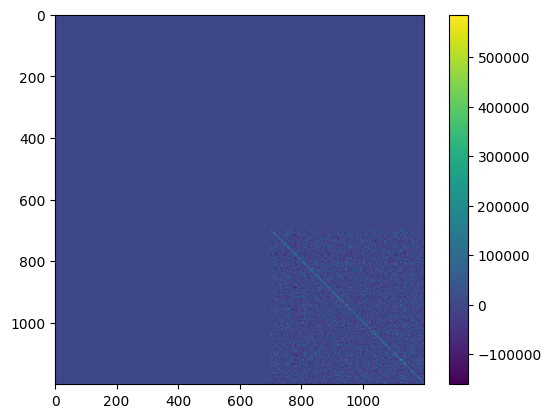

In [4]:
# compute the block matrix Sigma = [cov(w_int, w_int), cov(w_int, w_bndry), cov(w_int, nabla^4 w_int),
#                                   cov(w_bndry, w_int), cov(w_bndry, w_bndry), cov(w_bndry, nabla^4 w_bndry),
#                                   cov(nabla^4 w_int, w_int), cov(nabla^4 w_int, w_bndry), cov(nabla^4 w_int, nabla^4 w_int) ]
# not a function of theta..
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

n_block = 2 * num_interior + num_bndry
x_all = tf.concat([x_train, x_bndry], axis=0)
num_all = num_interior + num_bndry

# 11 - interior+bndry self-covariance
x_all_L = tf.expand_dims(x_all, axis=1)
x_all_R = tf.expand_dims(x_all, axis=0)
K11 = tf.constant(kernel2d_tf(x_all_L, x_all_R), dtype=DTYPE)

# 12 - interior+bndry cov with nabla^4 w on interior
x_interior_L = tf.expand_dims(x_train, axis=1)
K21 = tf.constant(kernel2d_bilapl_tf(x_interior_L, x_all_R), dtype=DTYPE)
# K12 = tf.transpose(K21)

# 22 - self-cov with nabla^4 w in interior
x_interior_R = tf.expand_dims(x_train, axis=0)
K22 = tf.constant(kernel2d_double_bilapl_tf(x_interior_L, x_interior_R), dtype=DTYPE)

print(f"{num_interior=} {num_all=}")
print(f"{K11.shape=} {K21.shape=} {K22.shape=}")

# assemble full covariance matrix
_row1 = tf.constant(tf.concat([K11, tf.transpose(K21)], axis=1))
_row2 = tf.constant(tf.concat([K21, K22], axis=1))
Kblock_prereg = tf.concat([_row1, _row2], axis=0)

print(f"done with full matrix assembly..")

# apply robust regularization w.r.t. the max eigenvalue, namely we add epsilon * I term to matrix
# where epsilon = alpha * lambda_max
alpha = 1e-5
eigvals = np.linalg.eigvalsh(Kblock_prereg)
max_eigval = np.max(eigvals)
eps = alpha * max_eigval

print("done with eigenvalues solve")

Kblock = tf.constant(Kblock_prereg + eps * tf.eye(n_block), dtype=DTYPE)

# show the matrix image to see if positive definite roughly
plt.imshow(Kblock)
plt.colorbar()

In [5]:
# define GP vectors and factor cov matrix into LU
# -----------------------------------------------

K_lu = tf.linalg.lu(Kblock)

w_ext = tf.zeros(shape=(num_bndry,1), dtype=DTYPE)
print(f"{w_ext.shape=}")
nabla4_w = q / D
nabla4_w2 = tf.reshape(nabla4_w, shape=(num_domain,1))
print(f"{nabla4_w2.shape=}")

num_x = 2 * num_interior + num_bndry

_temp = tf.concat([w_ext, nabla4_w2], axis=0)
fixed_vec = tf.constant(_temp, dtype=DTYPE)

theta_arr = tf.zeros(shape=(num_domain,1), dtype=DTYPE)
theta = theta_arr
# theta = tf.Variable(theta_arr, trainable=True, dtype=DTYPE)

w_ext.shape=TensorShape([200, 1])
nabla4_w2.shape=TensorShape([500, 1])


In [6]:
# compute matrices for Gauss-newton iteration
# let loss = x^T Cov^-1 x and x are the vectors we put into nMAP
# then x = [theta; 0; q/D]  with also x = A * theta + x0
A = tf.concat([tf.eye(num_domain), tf.zeros((num_domain + num_bndry, num_domain))], axis=0)
x0 = tf.concat([tf.zeros((num_domain+num_bndry, 1)), nabla4_w2], axis=0)

# now loss = (A*th + x0)^T * Cov^-1 * (A * th + x0)
# so linearization is loss approx th^T A^T * Cov^-1 * A * th + 2 * x0^T * Cov^-1 * A * th + x0^T * Cov^-1 * x0
# which is minimized w.r.t. th / theta with:
# (A^T * Cov^-1 * A)^-1 * th + A^T * Cov^-1 * x0 = 0 [a linear system in th]

In [7]:
# Gauss-newton iteration
import tensorflow as tf

xinit = A @ theta + x0
# print(f"{xinit=}")
init_loss = tf.tensordot(tf.transpose(xinit), xinit, axes=1)
init_loss_val = init_loss.numpy()[0,0]
print(f"{init_loss_val=}")

for inewton in range(4):
    # print(f"{A.shape=}")
    temp = tf.linalg.lu_solve(*K_lu, rhs=A)
    # print(f"{temp.shape=}")
    lhs = tf.transpose(A) @ temp

    temp2 = tf.linalg.lu_solve(*K_lu, rhs=x0)
    rhs = tf.transpose(A) @ temp2

    lhs_lu = tf.linalg.lu(lhs)
    theta = tf.linalg.lu_solve(*lhs_lu, -rhs)

    x = A @ theta + x0

    temp3 = tf.linalg.lu_solve(*K_lu, rhs=x)
    loss = tf.tensordot(tf.transpose(x), x, axes=1)
    loss_val = loss.numpy()[0,0]
    print(f"{loss_val=}")

# print(f"{theta=}")
w_full = x

init_loss_val=0.0007787533
loss_val=0.00077879836
loss_val=0.00077879836
loss_val=0.00077879836
loss_val=0.00077879836


In [8]:
# predict the values at a grid of points (a mesh) so we can view predicted contour of the solution
# using the mean interpolated from trained values
import numpy as np

n = 100
ngrid = n * n
_xgrid = np.linspace(0.0, a, n)
_ygrid = np.linspace(0.0, b, n)
X, Y = np.meshgrid(_xgrid, _ygrid)
xgrid = np.reshape(X, newshape=(ngrid,1))
ygrid = np.reshape(Y, newshape=(ngrid,1))
x_grid = np.concatenate([xgrid, ygrid], axis=1)

# old non-vectorized way
# K_train = np.array([[kernel2d(x_all[i,:], x_all[j,:]) for j in range(num_all)] for i in range(num_all)])
# K_cross = np.array([[kernel2d(x_grid[i,:], x_all[j,:]) for j in range(num_all)] for i in range(ngrid)])

# vectorized way like 100x faster
K_train = kernel2d_tf(x_all_L, x_all_R)
x_grid_L = tf.expand_dims(tf.constant(x_grid, dtype=DTYPE), axis=1)
K_cross = kernel2d_tf(x_grid_L, x_all_R)

max_eigval = np.max(np.linalg.eigvalsh(K_train))
W_grid = K_cross @ np.linalg.solve(K_train + 1e-5 * max_eigval * np.eye(num_all), w_full[:num_all,:])
W = np.reshape(W_grid, newshape=(n, n))

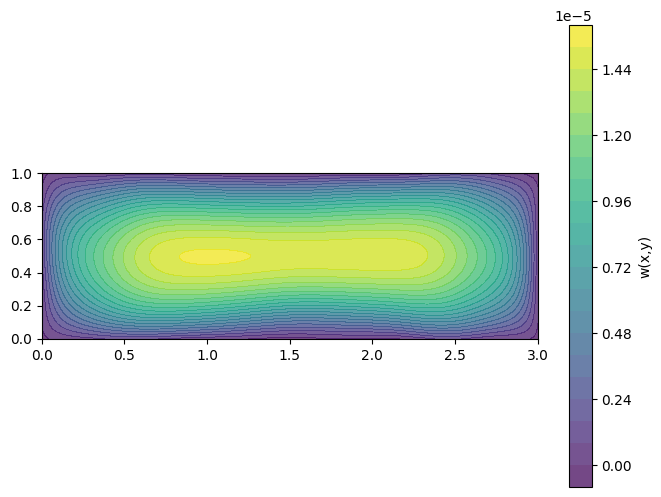

In [9]:
import matplotlib.pyplot as plt
# now plot the predicted solution contour
plt.figure(figsize=(8, 6))
colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
plt.gca().set_aspect('equal')
plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference

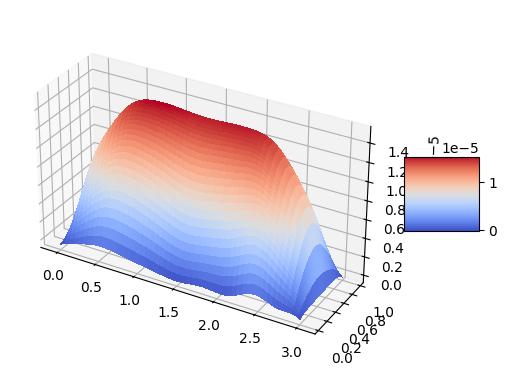

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
# now plot the predicted solution surface in 3d
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=1)
ax.set_aspect('equalxy')
plt.show()

In [11]:
# check the PDE loss by joint kernel from learned w(x,y) field
# already have K_train for the grid
# now get cross-covariance for predicting nabla^4 w
K_cross_nabla4 = kernel2d_bilapl_tf(x_grid_L, x_all_R)
nabla4_wgrid = K_cross_nabla4 @ np.linalg.solve(K_train + 1e-5 * max_eigval * np.eye(num_all), w_full[:num_all,:])
_temp = np.array([q_load(xgrid[i], ygrid[i]) for i in range(ngrid)])
q_grid = tf.constant(_temp, shape=(ngrid,1), dtype=DTYPE)
pde_resid = D * nabla4_wgrid - q_grid
norm_pde_resid = pde_resid / np.max(np.abs(q_grid.numpy()))
# print(f"{q=}")
# print(f"{norm_pde_resid=}")
print(f"{np.mean(D * nabla4_wgrid)=}")



np.mean(D * nabla4_wgrid)=1.048402


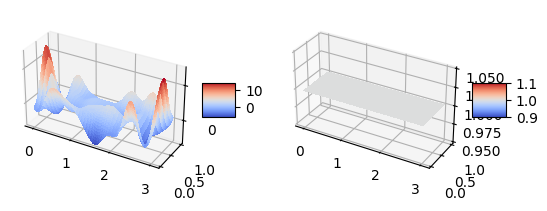

In [12]:
# plot contours of each : first the D * nabla^4 w(x,y)
fig, ax = plt.subplots(1,2, subplot_kw={"projection": "3d"})
nabla4_W = np.reshape(nabla4_wgrid, newshape=(n,n))
surf = ax[0].plot_surface(X, Y, D * nabla4_W, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=1)
ax[0].set_aspect('equalxy')

Qgrid = np.reshape(q_grid, newshape=(n,n))
surf = ax[1].plot_surface(X, Y, Qgrid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=1)
ax[1].set_aspect('equalxy')

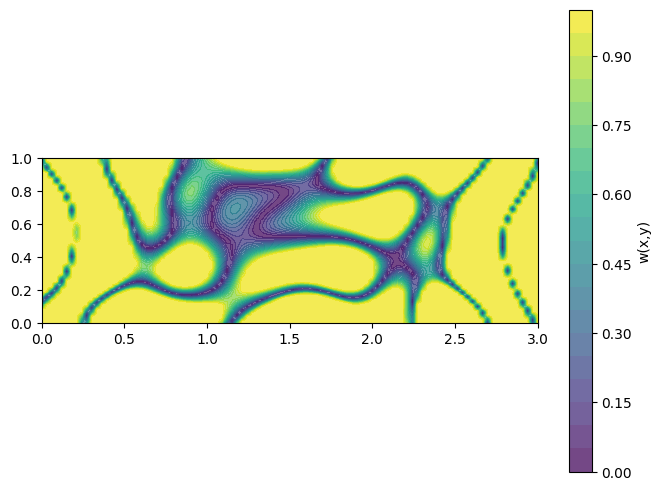

In [13]:
# show the relative error contours
plt.figure(figsize=(8, 6))
rel_err = np.clip(np.abs(norm_pde_resid), 0.0, 1.0)
REL_ERR = np.reshape(rel_err, newshape=(n,n))
colors = plt.contourf(X, Y, REL_ERR, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
plt.gca().set_aspect('equal')
plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference